In [22]:
import kagglehub
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torchvision import transforms
from ultralytics import YOLO
import seaborn as sns
import pandas as pd
from collections import Counter

In [1]:
pip install opencv-python


In [2]:
pip install ultralytics

In [3]:
!pip install timm

**LOADING DATASET**

In [5]:
# --- Image Dataset ---
image_path = kagglehub.dataset_download("mdfahimbinamin/100k-vehicle-dashcam-image-dataset")
image_files = []
for root, dirs, files in os.walk(image_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

print("Found image files:", len(image_files))

Found image files: 100000


In [6]:
# --- Video Dataset ---
video_path = kagglehub.dataset_download("tapakah68/videos-around-cars")
video_files = []
for root, dirs, files in os.walk(video_path):
    for file in files:
        if file.endswith(('.mp4', '.avi', '.mov')):
            video_files.append(os.path.join(root, file))

print("Found video files:", len(video_files))

Found video files: 10


**MERGING IMAGES AND VIDEO DATASET**

In [7]:
# 🧹 Preprocessing Images (Clean invalid images)

valid_images = []
for img_path in image_files:
    try:
        img = Image.open(img_path).convert("RGB")
        valid_images.append(img_path)
    except:
        print("Bad image removed:", img_path)

print("Valid images after cleaning:", len(valid_images))

Valid images after cleaning: 100000


In [8]:
# 🎥 Extract Video Frames
# ====================
video_frames = []

for video_path in video_files:
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Failed to open video:", video_path)
        continue

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to PIL Image
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(frame_rgb)
        video_frames.append(pil_img)

        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames from {video_path}")

print("Total video frames extracted:", len(video_frames))

Extracted 1094 frames from /kaggle/input/videos-around-cars/files/Videos around cars/5.mp4
Extracted 1054 frames from /kaggle/input/videos-around-cars/files/Videos around cars/3.mp4
Extracted 1078 frames from /kaggle/input/videos-around-cars/files/Videos around cars/8.mp4
Extracted 954 frames from /kaggle/input/videos-around-cars/files/Videos around cars/9.mp4
Extracted 999 frames from /kaggle/input/videos-around-cars/files/Videos around cars/1.mp4
Extracted 1033 frames from /kaggle/input/videos-around-cars/files/Videos around cars/6.mp4
Extracted 1101 frames from /kaggle/input/videos-around-cars/files/Videos around cars/4.mp4
Extracted 1058 frames from /kaggle/input/videos-around-cars/files/Videos around cars/10.mp4
Extracted 1058 frames from /kaggle/input/videos-around-cars/files/Videos around cars/7.mp4
Extracted 1230 frames from /kaggle/input/videos-around-cars/files/Videos around cars/2.mp4
Total video frames extracted: 10659


In [9]:
# 📦 Merge Image + Video Frames → Unified Dataset

unified_dataset = valid_images + video_frames
print("Unified dataset size:", len(unified_dataset))

random.shuffle(unified_dataset)

Unified dataset size: 110659


**Models on Dataset**

In [10]:
# 🚀 Load Perception Models
# ====================
det_model = YOLO("yolov8n.pt")
seg_model = YOLO("yolov8n-seg.pt")
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

print("Models loaded.")

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Models loaded.


**PERCEPTION MODELS**

In [11]:
def run_object_detection(image):
    result = det_model.predict(image)
    det_img = result[0].plot()
    detections = []
    if result[0].boxes is not None:
        for box in result[0].boxes:
            cls_id = int(box.cls[0])
            conf = box.conf[0].item()
            class_name = det_model.names[cls_id]
            detections.append(class_name)
    return det_img, detections

In [12]:
def run_road_segmentation(image):
    result = seg_model.predict(image)
    seg_img = result[0].plot()
    return seg_img

In [13]:
def run_depth_estimation(pil_image):
    original = pil_image.convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ])
    img_tensor = transform(original).unsqueeze(0)

    with torch.no_grad():
        prediction = midas(img_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=original.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()
    depth_norm = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
    depth_color = cv2.applyColorMap(depth_norm.astype(np.uint8), cv2.COLORMAP_MAGMA)

    return depth_color, depth

In [36]:
# ====================
# 🧠 Perceive Image Helper Function (perceive_image)
# ====================

def perceive_image(input_data):
    # Check if path or PIL
    if isinstance(input_data, str):
        original = Image.open(input_data).convert("RGB")
        image_for_yolo = input_data
    else:
        original = input_data.convert("RGB")
        image_for_yolo = np.array(original)

    # Run perception modules
    det_img, detections = run_object_detection(image_for_yolo)
    seg_img = run_road_segmentation(image_for_yolo)
    depth_color, depth = run_depth_estimation(original)

    # Combine results
    result = {
        "original": original,
        "detection_image": det_img,
        "segmentation_image": seg_img,
        "depth_image": depth_color,
        "detections": detections,
        "depth_mean": depth.mean()
    }

    return result


In [49]:
def summarize_detections(detections):
    """
    Summarize detections (counts per class).
    """
    counts = Counter(detections)
    summary = ', '.join([f"{v} {k}(s)" for k, v in counts.items()])
    return summary


In [51]:
def show_perception_result(results, title="Perception Output"):
    """
    Show Object Detection + Road Segmentation + Depth Estimation side by side with summary
    """
    detection_summary = summarize_detections(results["detections"])

    fig, axs = plt.subplots(1, 3, figsize=(24, 10))

    axs[0].imshow(results["detection_image"])
    axs[0].set_title(f"Object Detection\n{detection_summary}", fontsize=16)
    axs[0].axis("off")

    axs[1].imshow(results["segmentation_image"])
    axs[1].set_title("Road/Lane Segmentation", fontsize=16)
    axs[1].axis("off")

    axs[2].imshow(results["depth_image"])
    axs[2].set_title("Depth Estimation", fontsize=16)
    axs[2].axis("off")

    plt.suptitle(title, fontsize=20)
    plt.show()

**FEATURE EXTRACTION**

In [14]:
results = []

for sample in random.sample(unified_dataset, 50):
    if isinstance(sample, str):
        original = Image.open(sample).convert("RGB")
        image_for_yolo = sample
    else:
        original = sample.convert("RGB")
        image_for_yolo = np.array(original)

    det_img, detections = run_object_detection(image_for_yolo)
    seg_img = run_road_segmentation(image_for_yolo)
    depth_color, depth = run_depth_estimation(original)


image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/val/c0945c0c-e16c694a.jpg: 384x640 4 persons, 1 bicycle, 3 cars, 1 truck, 170.8ms
Speed: 2.1ms preprocess, 170.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/val/c0945c0c-e16c694a.jpg: 384x640 3 persons, 2 bicycles, 3 cars, 1 bus, 2 trucks, 113.1ms
Speed: 1.9ms preprocess, 113.1ms inference, 58.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/12dc1ad6-9648497e.jpg: 384x640 (no detections), 107.5ms
Speed: 1.8ms preprocess, 107.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/12dc1ad6-9648497e.jpg: 384x640 1 car, 101.4ms
Speed: 1.6ms preprocess, 101.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/28e362ca-c1aab

In [15]:
 result = {
        "detections": detections,
        "object_count": len(detections),
        "depth_mean": depth.mean()
    }

In [16]:
results.append(result)

print("Finished extracting features")

Finished extracting features


**VISUALISATION**

In [19]:
# Create dataframe
df = pd.DataFrame(results)

# Expand detections into flat list
all_detected_classes = []
for dets in df["detections"]:
    all_detected_classes.extend(dets)

In [23]:
# Count detected objects
class_counts = Counter(all_detected_classes)

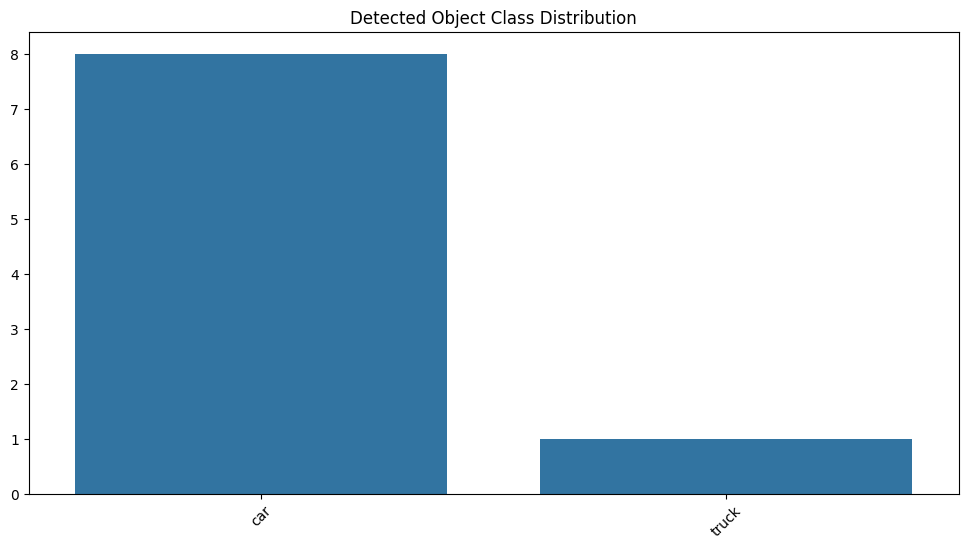

In [24]:
# Bar plot for most common detected objects
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Detected Object Class Distribution")
plt.show()

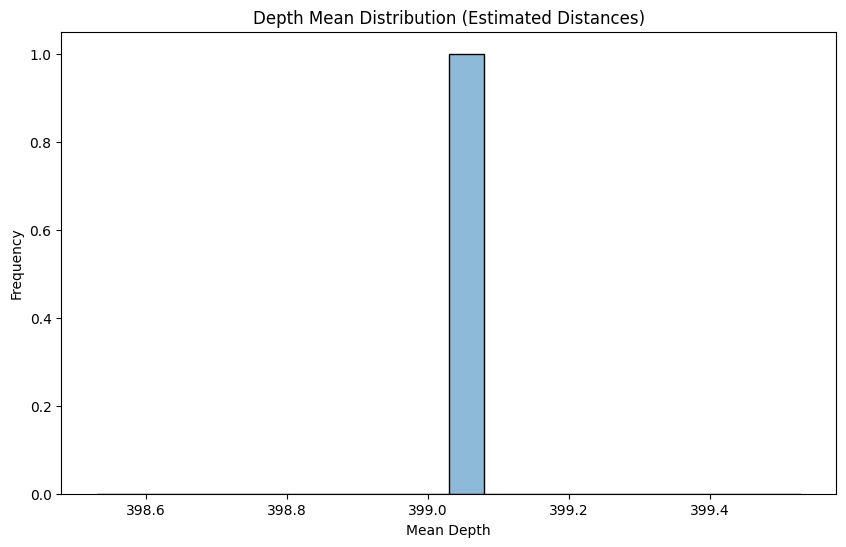

In [25]:
# Depth mean distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["depth_mean"], bins=20, kde=True)
plt.title("Depth Mean Distribution (Estimated Distances)")
plt.xlabel("Mean Depth")
plt.ylabel("Frequency")
plt.show()

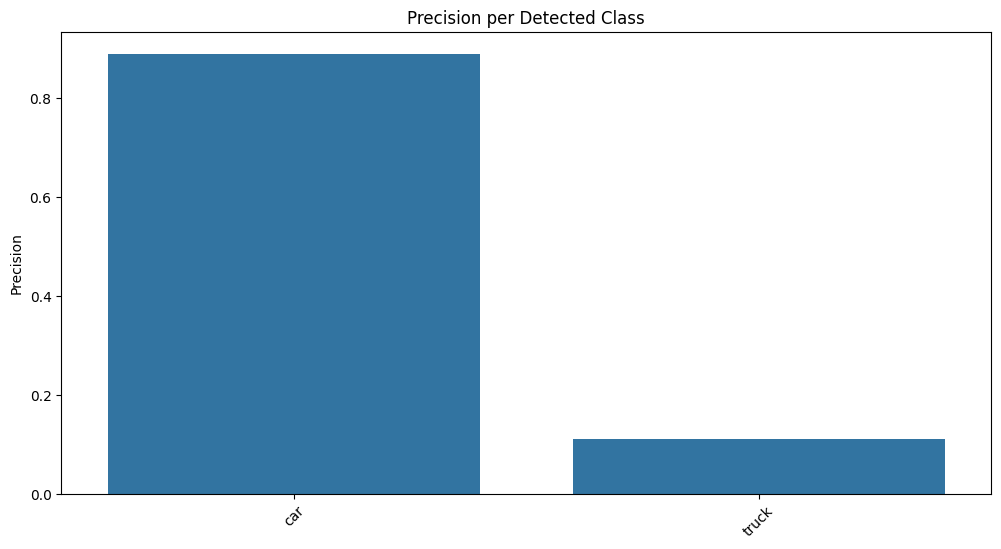

In [29]:
# Visualize precision per class
plt.figure(figsize=(12, 6))
sns.barplot(x=list(precision_per_class.keys()), y=list(precision_per_class.values()))
plt.xticks(rotation=45)
plt.title("Precision per Detected Class")
plt.ylabel("Precision")
plt.show()

**EVALUATION METRICS**

In [27]:
unique_classes = list(class_counts.keys())
matrix_data = []

for cls in unique_classes:
    matrix_data.append(class_counts[cls])

total_samples = len(df)
samples_with_objects = df[df["object_count"] > 0].shape[0]

# Accuracy proxy → How many images had objects detected
detection_accuracy = samples_with_objects / total_samples

# Precision per class → Of total detections, how much percentage was each class
total_detections = sum(class_counts.values())

precision_per_class = {}
for cls in unique_classes:
    precision_per_class[cls] = class_counts[cls] / total_detections


In [28]:
# Show metrics
print("\n===== EVALUATION METRICS =====")
print(f"Detection Accuracy (samples with objects): {detection_accuracy:.2f}")

print("\nPrecision per Detected Class:")
for cls, prec in precision_per_class.items():
    print(f"{cls}: {prec:.2f}")


===== EVALUATION METRICS =====
Detection Accuracy (samples with objects): 1.00

Precision per Detected Class:
car: 0.89
truck: 0.11


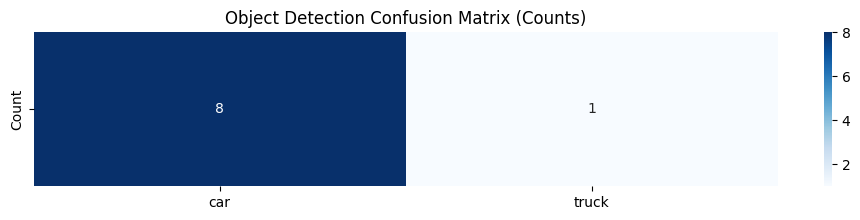

In [30]:
cm = np.array(matrix_data).reshape(1, -1)

plt.figure(figsize=(12, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=["Count"])
plt.title("Object Detection Confusion Matrix (Counts)")
plt.show()

**TESTING **

Running perception on: /kaggle/input/100k-vehicle-dashcam-image-dataset/train/1127aff5-03496050.jpg

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/1127aff5-03496050.jpg: 384x640 4 cars, 2 buss, 1 truck, 37.7ms
Speed: 2.0ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/1127aff5-03496050.jpg: 384x640 5 cars, 2 trucks, 92.5ms
Speed: 1.6ms preprocess, 92.5ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


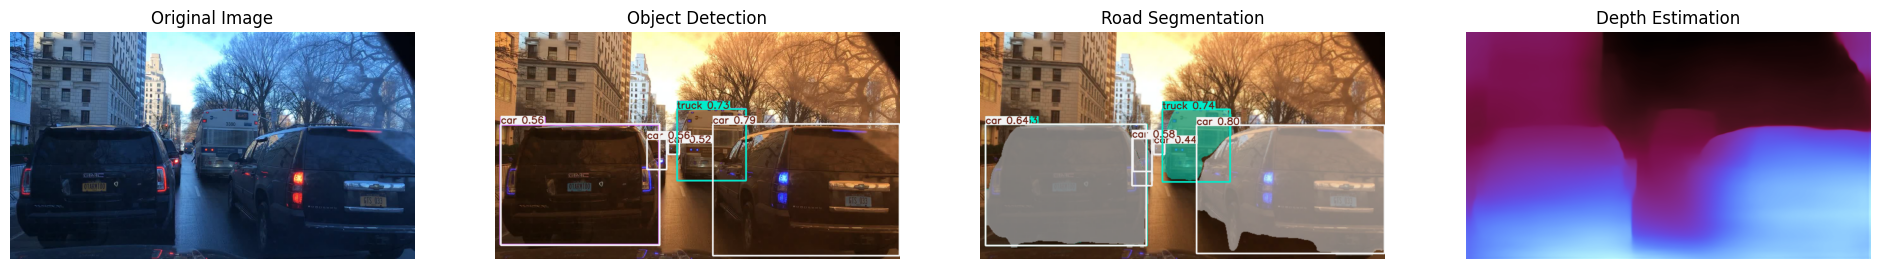

Detected objects: ['car', 'truck', 'bus', 'car', 'car', 'car', 'bus']
Mean depth: 304.8433


In [37]:
from random import choice

test_img_path = choice(image_files)

print("Running perception on:", test_img_path)

results = perceive_image(test_img_path)

# Visualize the results
fig, axs = plt.subplots(1, 4, figsize=(24, 8))

axs[0].imshow(results["original"])
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(results["detection_image"])
axs[1].set_title("Object Detection")
axs[1].axis("off")

axs[2].imshow(results["segmentation_image"])
axs[2].set_title("Road Segmentation")
axs[2].axis("off")

axs[3].imshow(results["depth_image"])
axs[3].set_title("Depth Estimation")
axs[3].axis("off")

plt.show()

print("Detected objects:", results["detections"])
print("Mean depth:", results["depth_mean"])


In [39]:
from random import choice
test_img_path = choice(image_files)

perceive_image(test_img_path)


image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/8ad6b8d6-c3c450de.jpg: 384x640 6 cars, 39.7ms
Speed: 2.1ms preprocess, 39.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/8ad6b8d6-c3c450de.jpg: 384x640 7 cars, 94.8ms
Speed: 1.6ms preprocess, 94.8ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


{'original': <PIL.Image.Image image mode=RGB size=1280x720>,
 'detection_image': array([[[ 6,  2,  7],
         [ 8,  4,  9],
         [12,  8, 13],
         ...,
         [ 4,  1,  3],
         [ 4,  1,  3],
         [ 4,  1,  3]],
 
        [[ 7,  3,  8],
         [ 9,  5, 10],
         [11,  7, 12],
         ...,
         [ 4,  1,  3],
         [ 4,  1,  3],
         [ 4,  1,  3]],
 
        [[ 8,  4,  9],
         [ 9,  5, 10],
         [11,  7, 12],
         ...,
         [ 4,  1,  3],
         [ 4,  1,  3],
         [ 4,  1,  3]],
 
        ...,
 
        [[11, 10, 19],
         [11, 10, 19],
         [11, 10, 19],
         ...,
         [ 2,  1,  3],
         [ 2,  1,  3],
         [ 2,  1,  3]],
 
        [[10,  9, 18],
         [10,  9, 18],
         [10,  9, 18],
         ...,
         [ 2,  1,  3],
         [ 2,  1,  3],
         [ 2,  1,  3]],
 
        [[ 8,  7, 16],
         [ 8,  7, 16],
         [ 8,  7, 16],
         ...,
         [ 2,  1,  3],
         [ 2,  1,  3],
 

In [52]:
def process_video(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video.")
        return

    frame_count = 0
    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to PIL
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(frame_rgb)

        result = perceive_image(pil_img)
        show_perception_result(result, title=f"Video Frame {frame_count + 1}")

        frame_count += 1

    cap.release()


Running perception on video: /kaggle/input/videos-around-cars/files/Videos around cars/2.mp4

0: 288x640 1 suitcase, 1 cell phone, 35.4ms
Speed: 2.6ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 train, 86.7ms
Speed: 1.6ms preprocess, 86.7ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


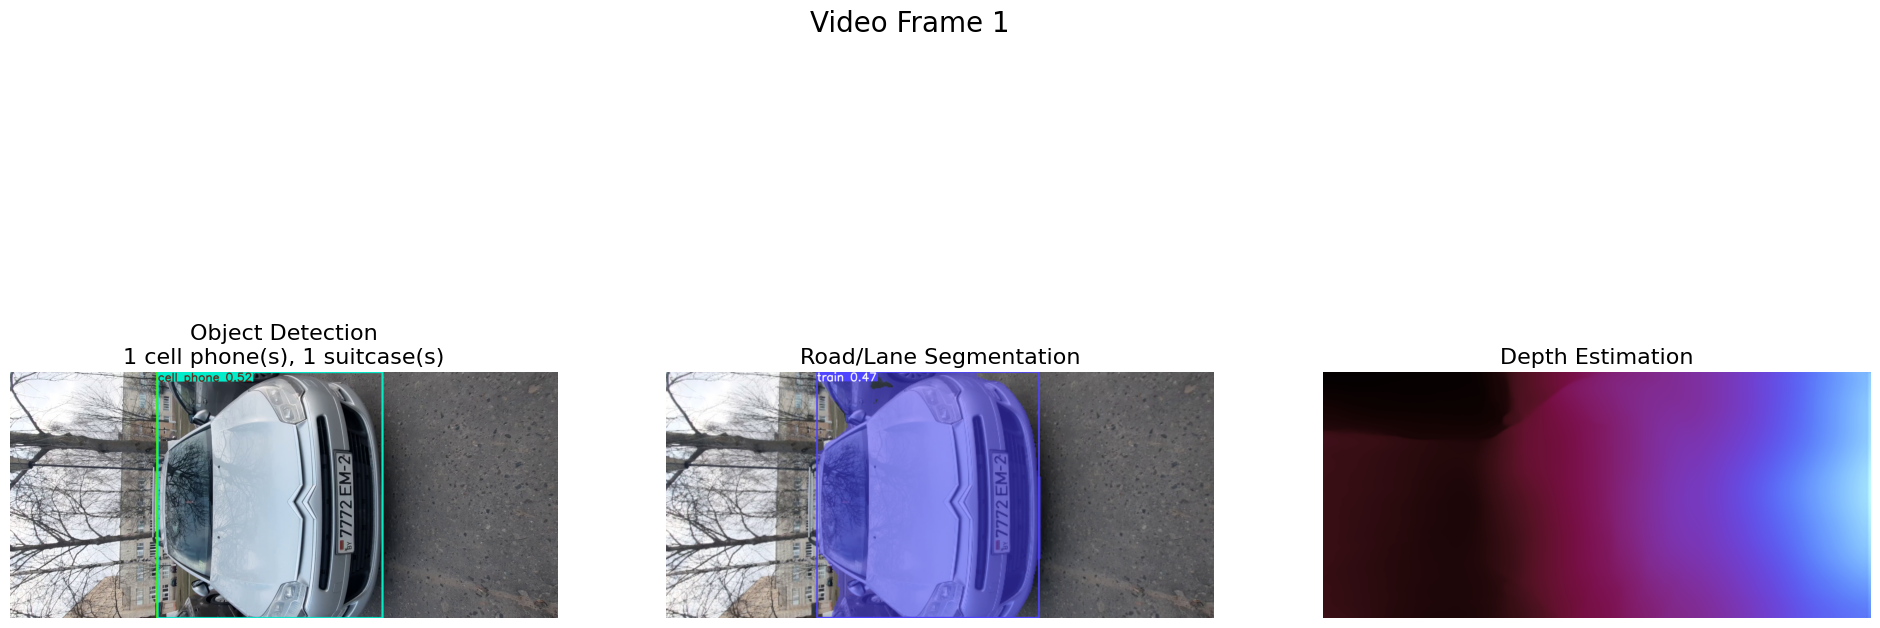

In [55]:
video_sample = random.choice(video_files)
print("Running perception on video:", video_sample)

process_video(video_sample, num_frames=1)

Running perception on sample 1

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/a1140112-70dbd27d.jpg: 384x640 2 cars, 2 buss, 3 trucks, 39.0ms
Speed: 2.1ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/a1140112-70dbd27d.jpg: 384x640 2 cars, 1 bus, 2 trucks, 97.0ms
Speed: 1.8ms preprocess, 97.0ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


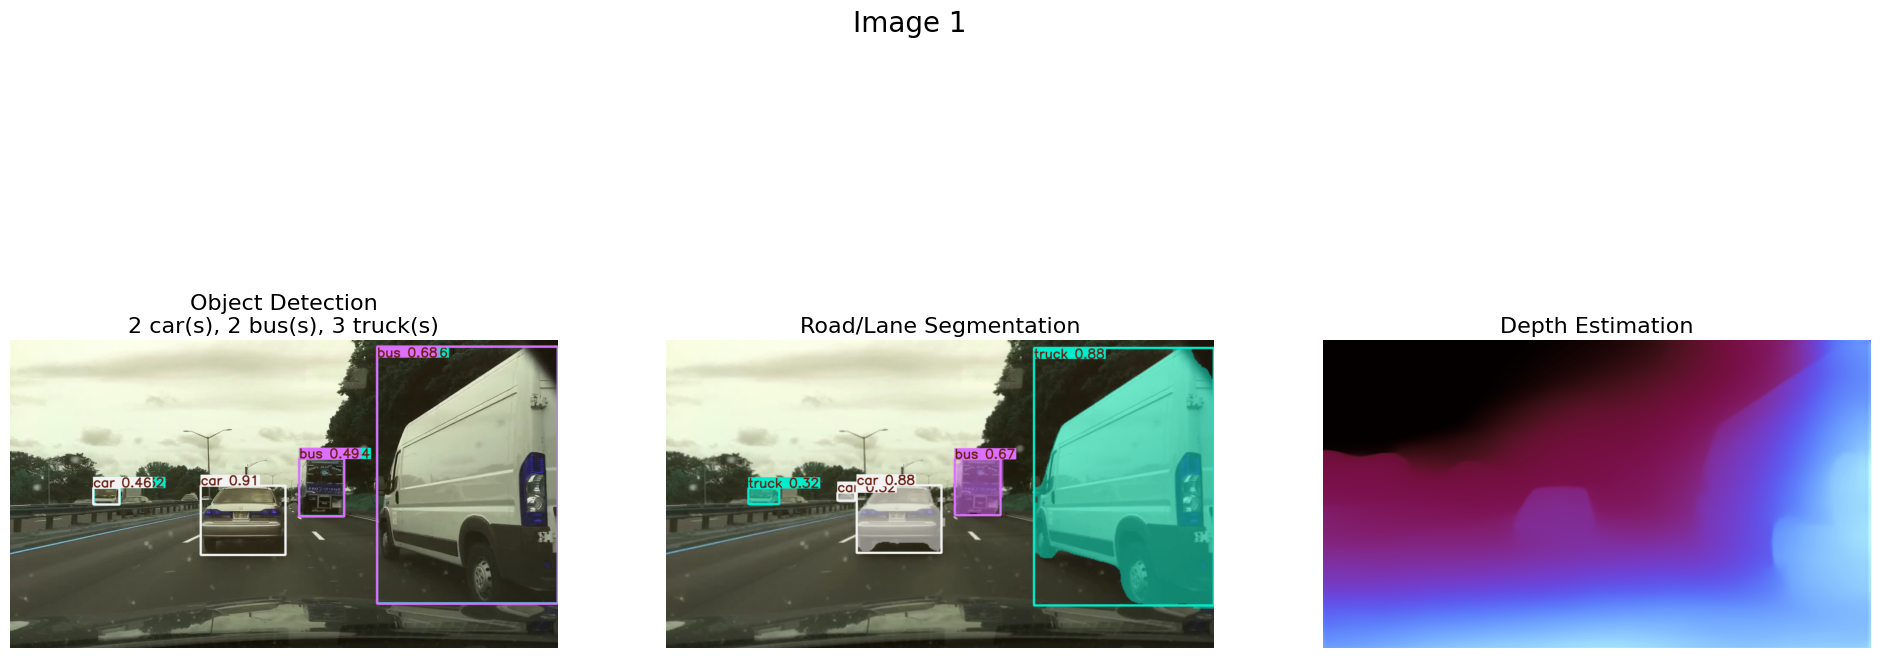

Running perception on sample 2

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/99bdc1d6-74cf35ab.jpg: 384x640 2 cars, 1 bus, 1 truck, 1 traffic light, 36.6ms
Speed: 2.0ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/99bdc1d6-74cf35ab.jpg: 384x640 1 car, 1 bus, 1 truck, 1 traffic light, 92.8ms
Speed: 1.8ms preprocess, 92.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


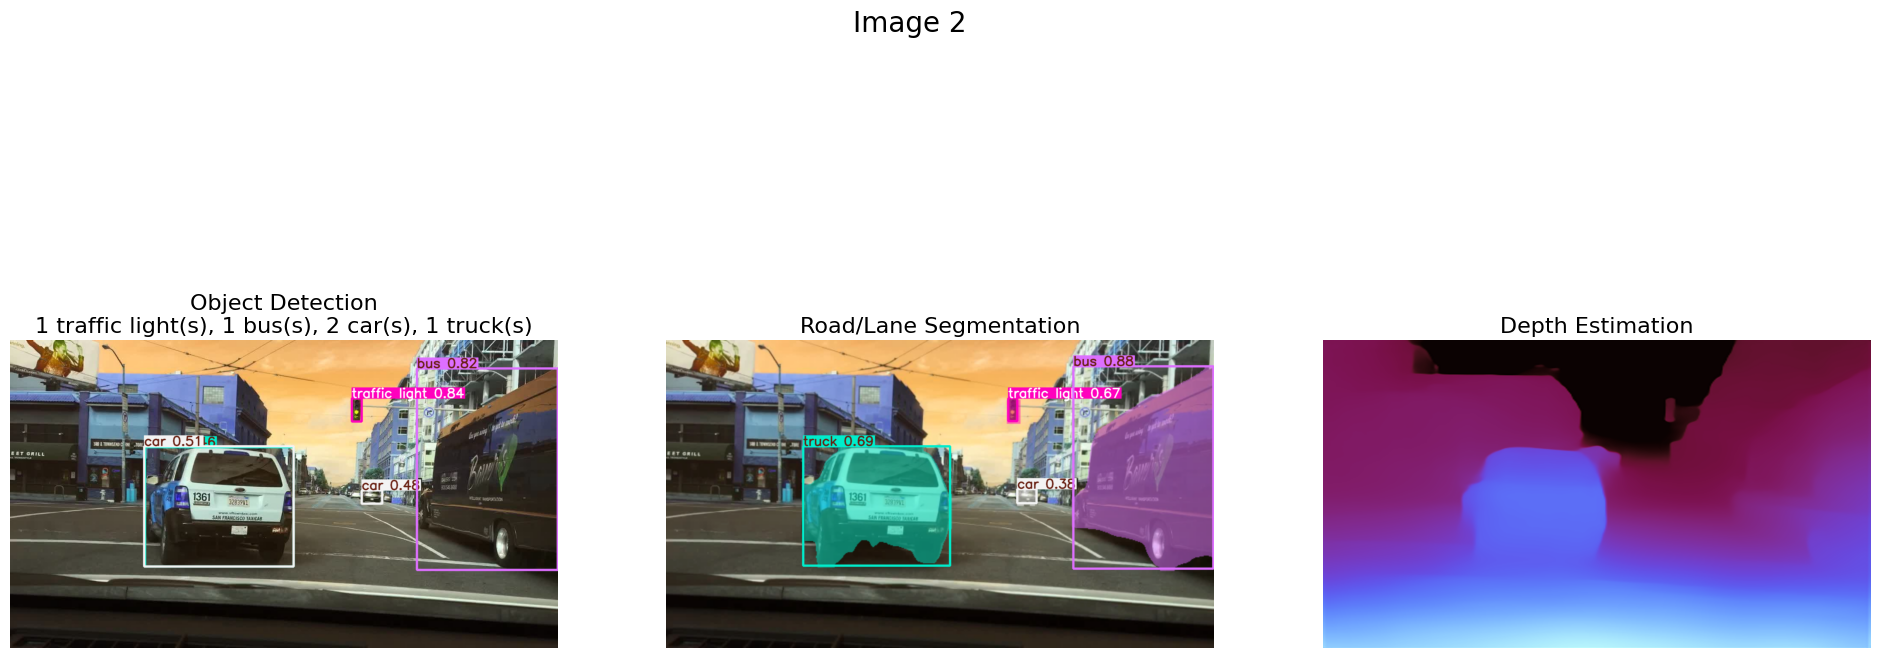

Running perception on sample 3

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/8abcc703-c1d897f4.jpg: 384x640 1 person, 5 cars, 1 truck, 39.6ms
Speed: 2.0ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/8abcc703-c1d897f4.jpg: 384x640 1 person, 8 cars, 2 trucks, 94.0ms
Speed: 1.6ms preprocess, 94.0ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


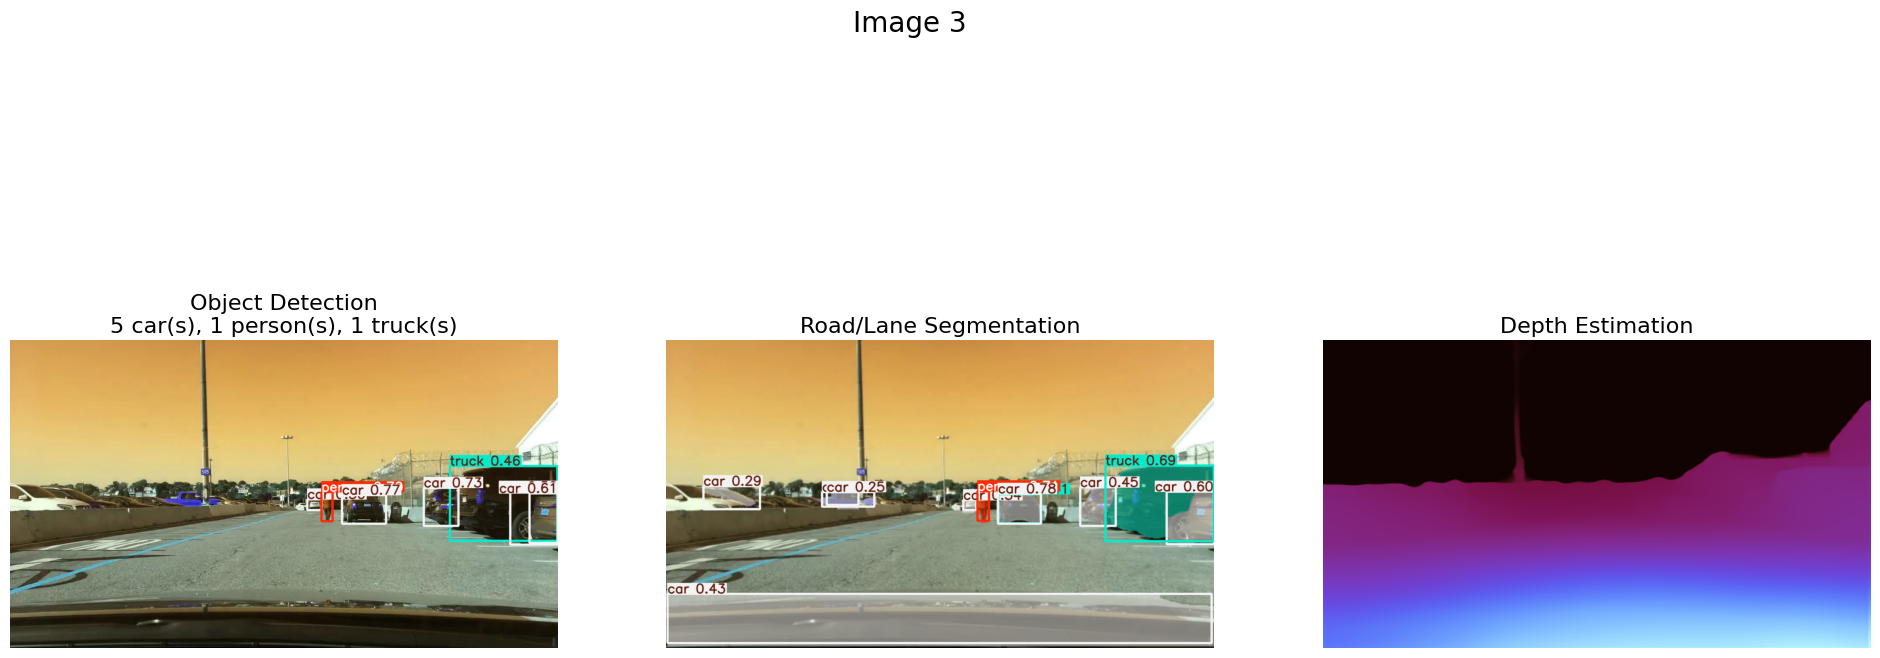

Running perception on sample 4

0: 384x640 (no detections), 36.8ms
Speed: 2.1ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 65.8ms
Speed: 1.8ms preprocess, 65.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


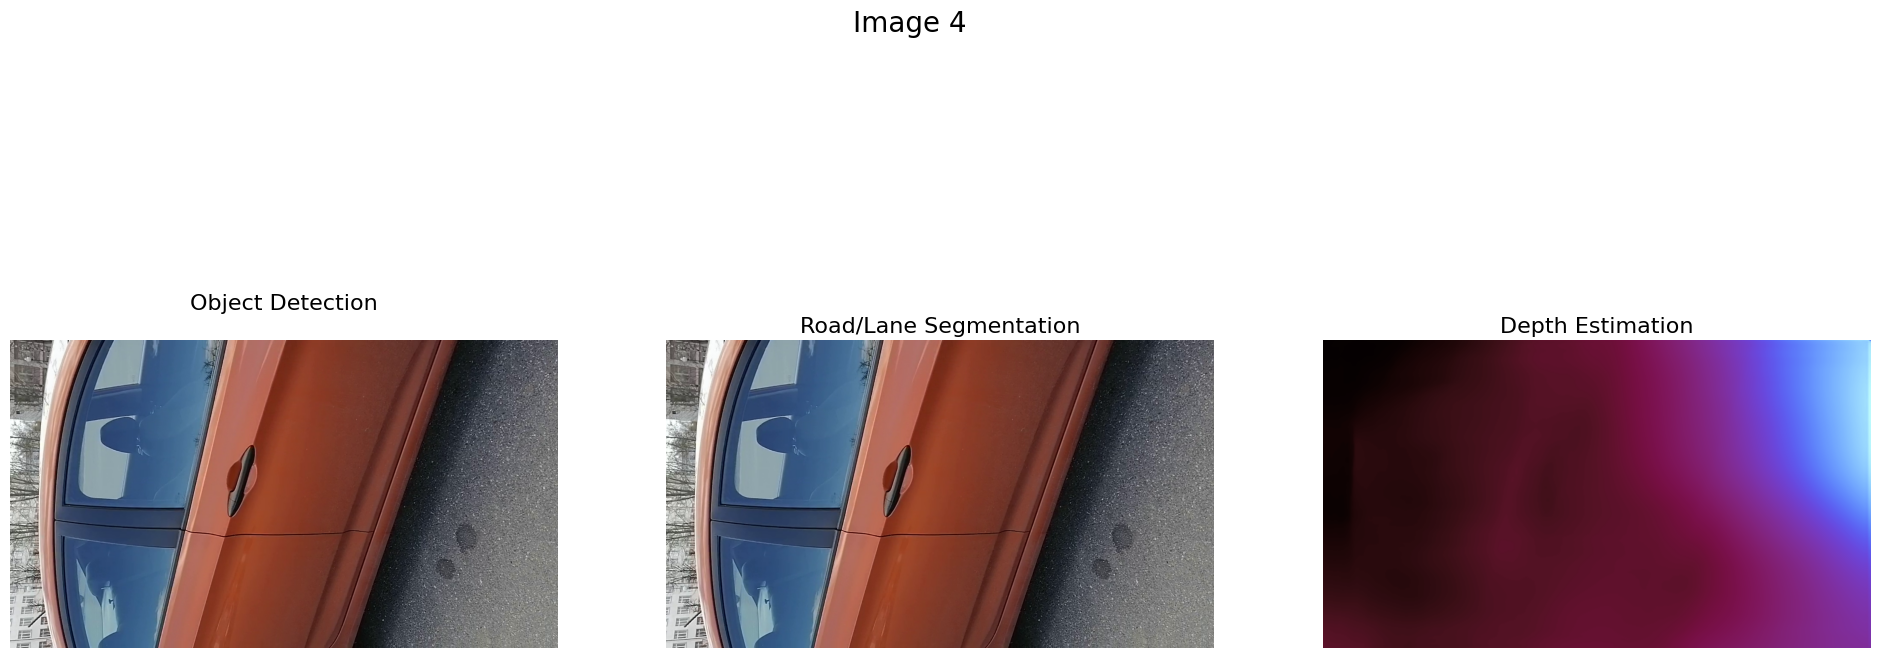

Running perception on sample 5

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/val/baeab53a-2e79e160.jpg: 384x640 4 cars, 1 traffic light, 36.6ms
Speed: 1.8ms preprocess, 36.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/val/baeab53a-2e79e160.jpg: 384x640 1 person, 4 cars, 94.1ms
Speed: 1.7ms preprocess, 94.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


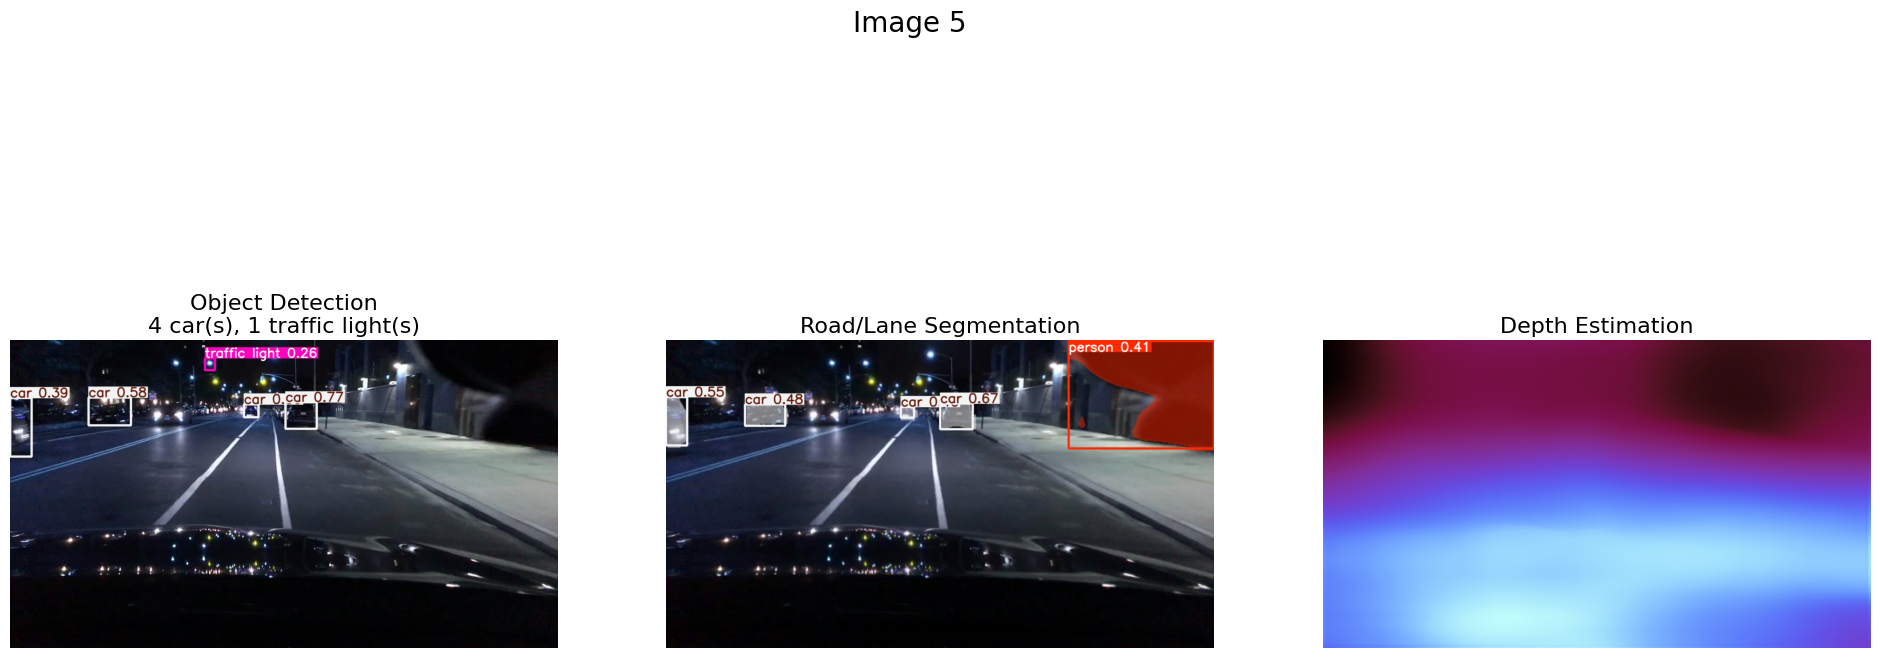

Running perception on sample 6

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/test/f4c5c2e0-ff1ad9f6.jpg: 384x640 7 cars, 1 bus, 1 truck, 38.0ms
Speed: 1.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/test/f4c5c2e0-ff1ad9f6.jpg: 384x640 7 cars, 1 bus, 1 truck, 44.3ms
Speed: 2.0ms preprocess, 44.3ms inference, 55.0ms postprocess per image at shape (1, 3, 384, 640)


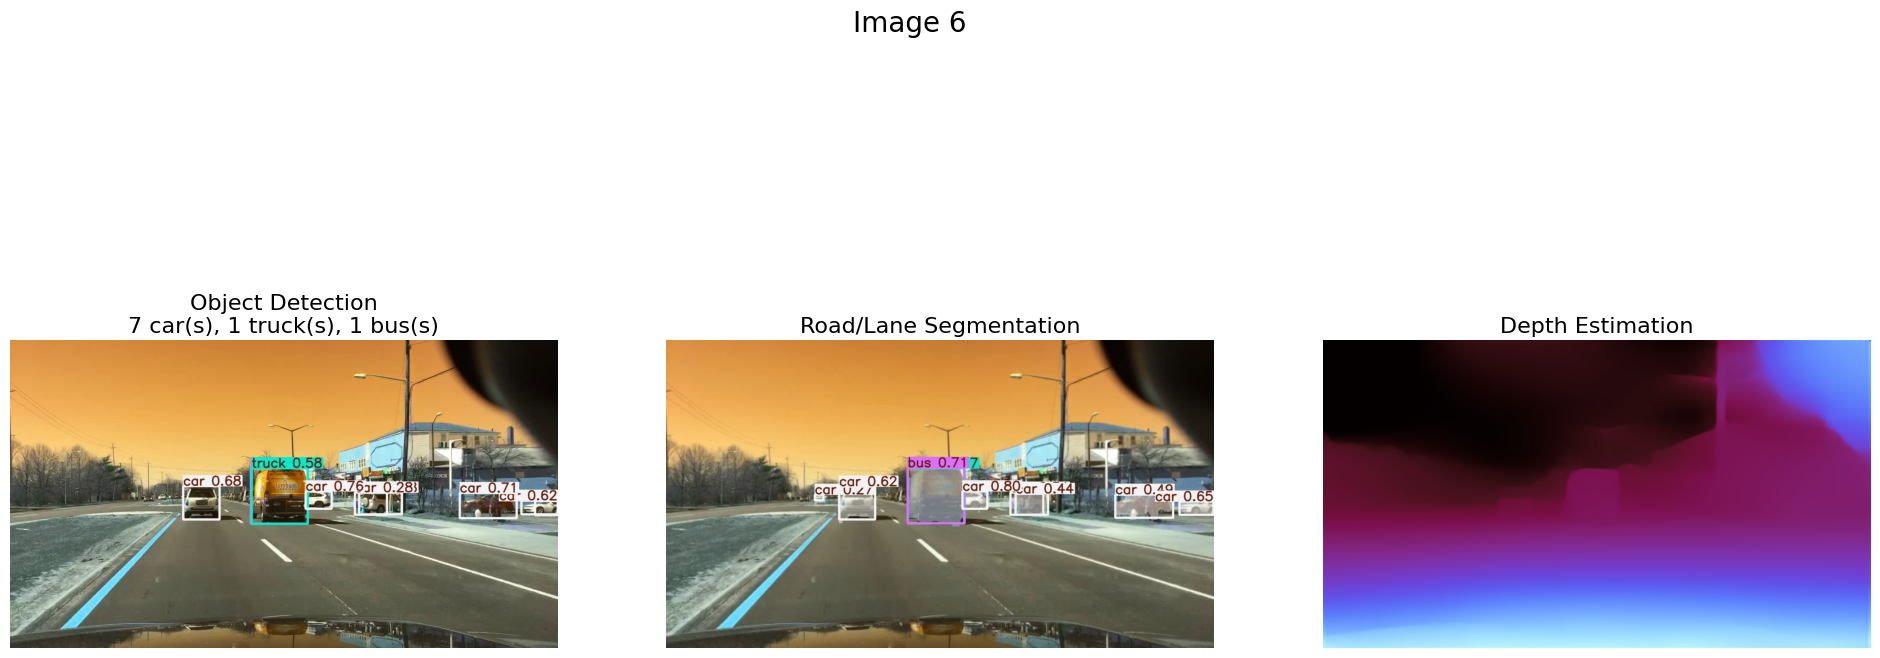

Running perception on sample 7

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/81389cfc-33738342.jpg: 384x640 8 cars, 1 truck, 37.9ms
Speed: 1.9ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/81389cfc-33738342.jpg: 384x640 9 cars, 1 truck, 98.5ms
Speed: 1.6ms preprocess, 98.5ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


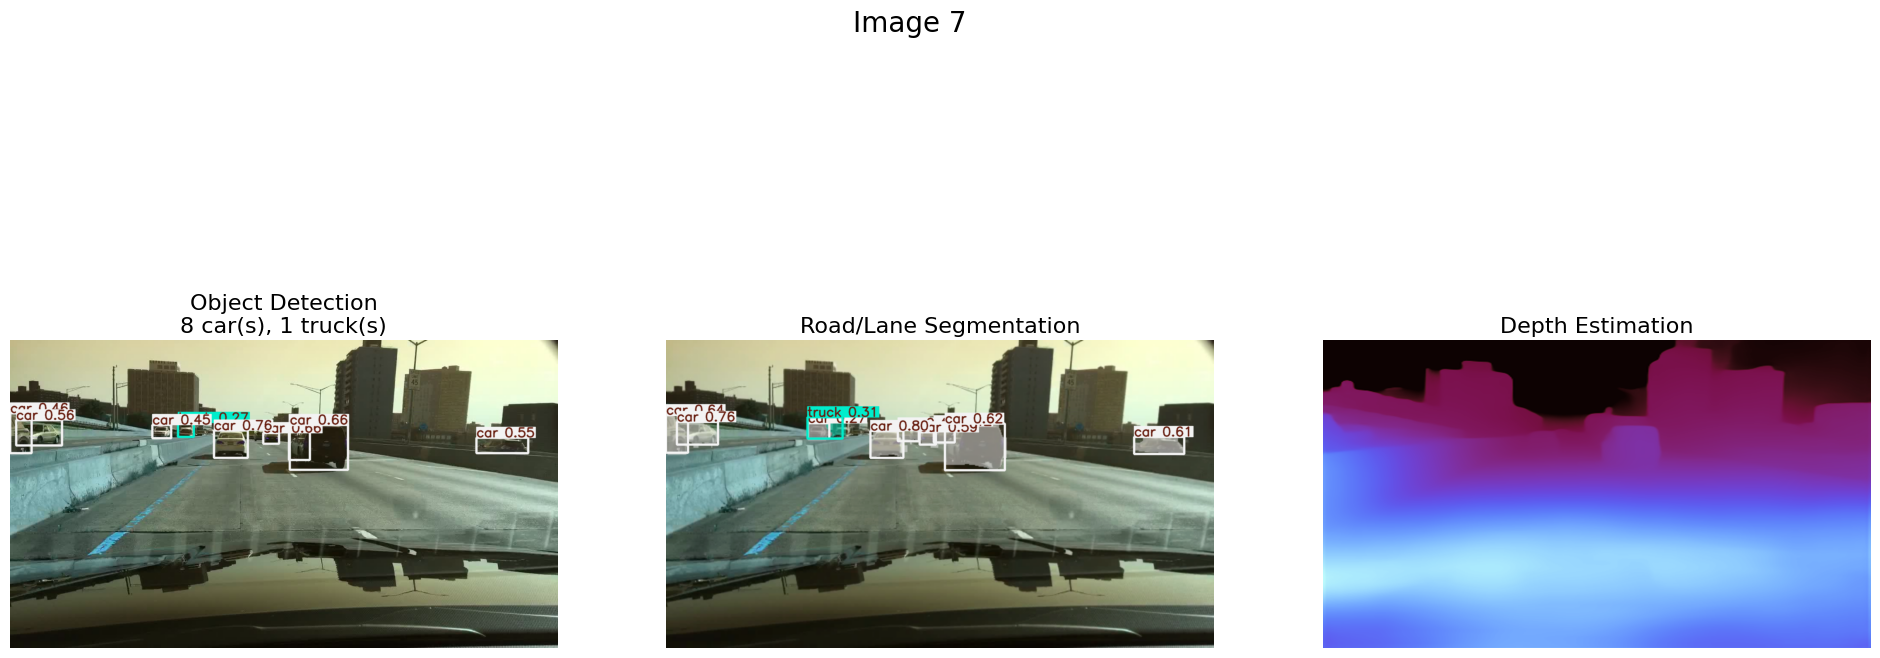

Running perception on sample 8

0: 384x640 1 refrigerator, 38.6ms
Speed: 1.9ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 refrigerators, 44.9ms
Speed: 1.9ms preprocess, 44.9ms inference, 52.9ms postprocess per image at shape (1, 3, 384, 640)


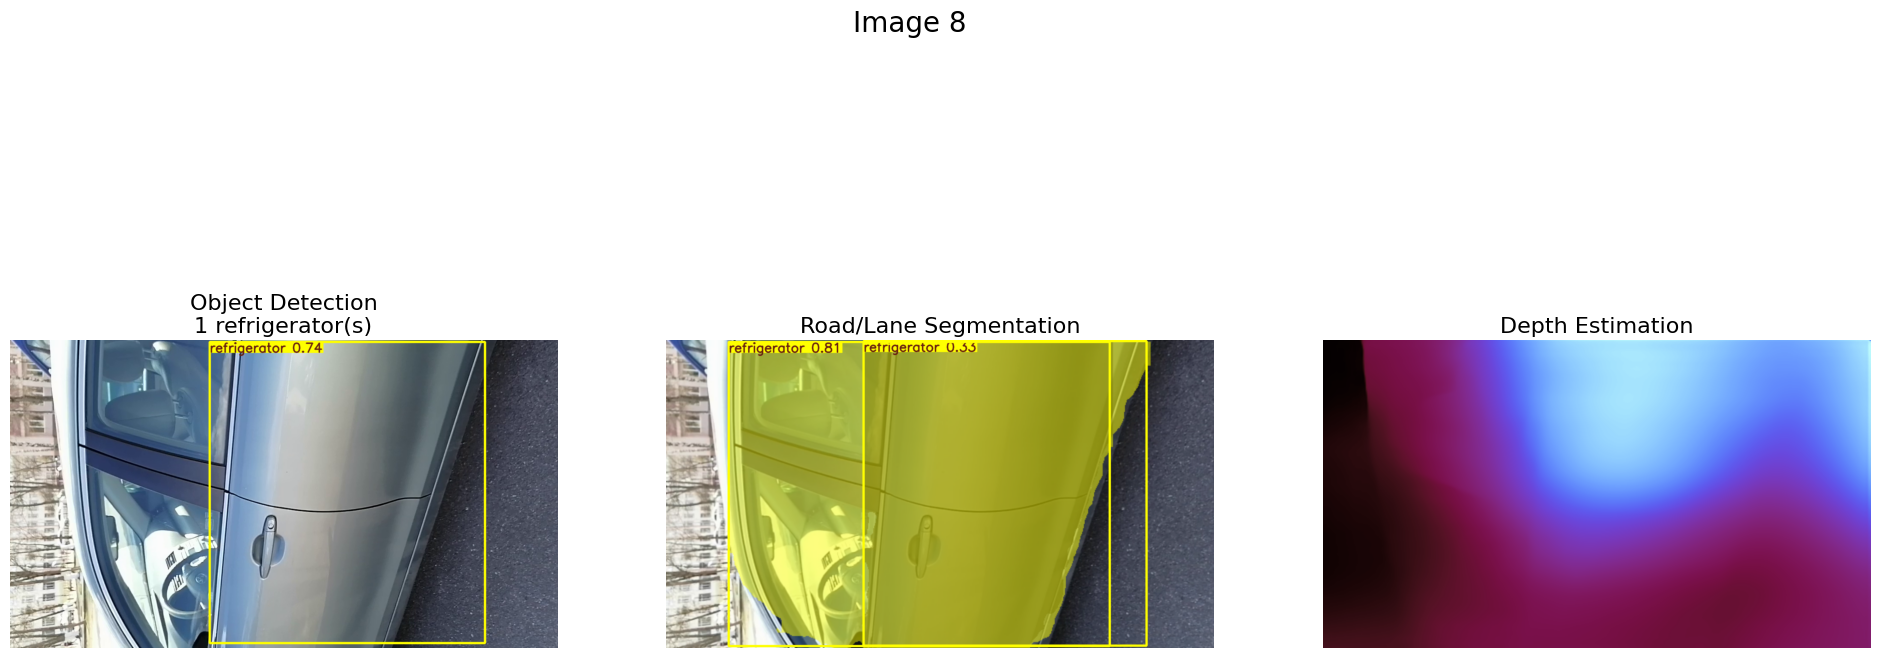

Running perception on sample 9

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/6740dbe7-ec8c030a.jpg: 384x640 3 cars, 36.0ms
Speed: 1.8ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/6740dbe7-ec8c030a.jpg: 384x640 1 person, 2 cars, 102.1ms
Speed: 23.4ms preprocess, 102.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


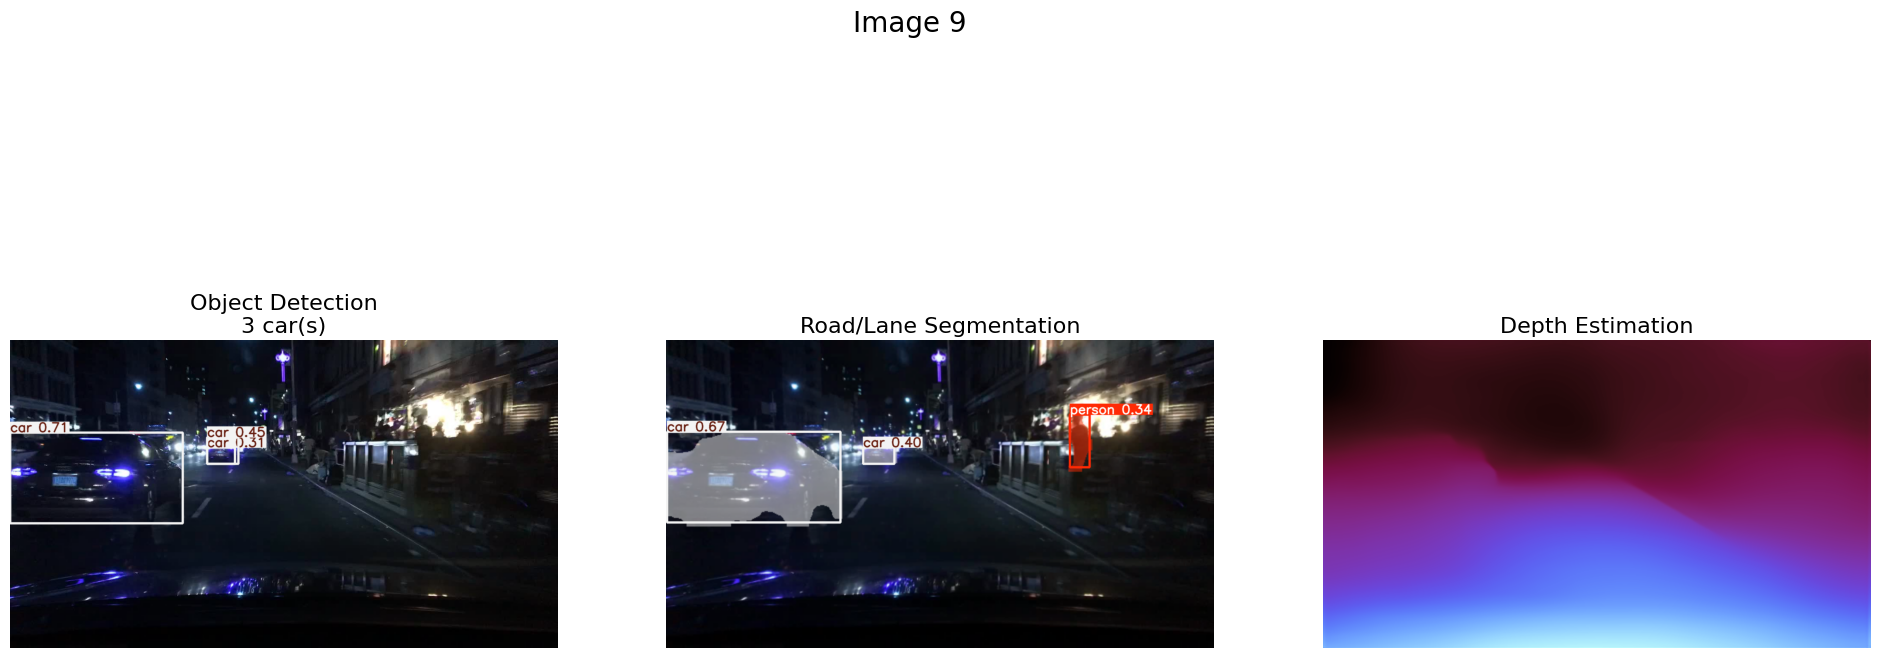

Running perception on sample 10

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/3940c668-aeee21e6.jpg: 384x640 2 cars, 1 traffic light, 38.1ms
Speed: 1.9ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/100k-vehicle-dashcam-image-dataset/train/3940c668-aeee21e6.jpg: 384x640 3 cars, 1 traffic light, 93.2ms
Speed: 1.5ms preprocess, 93.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


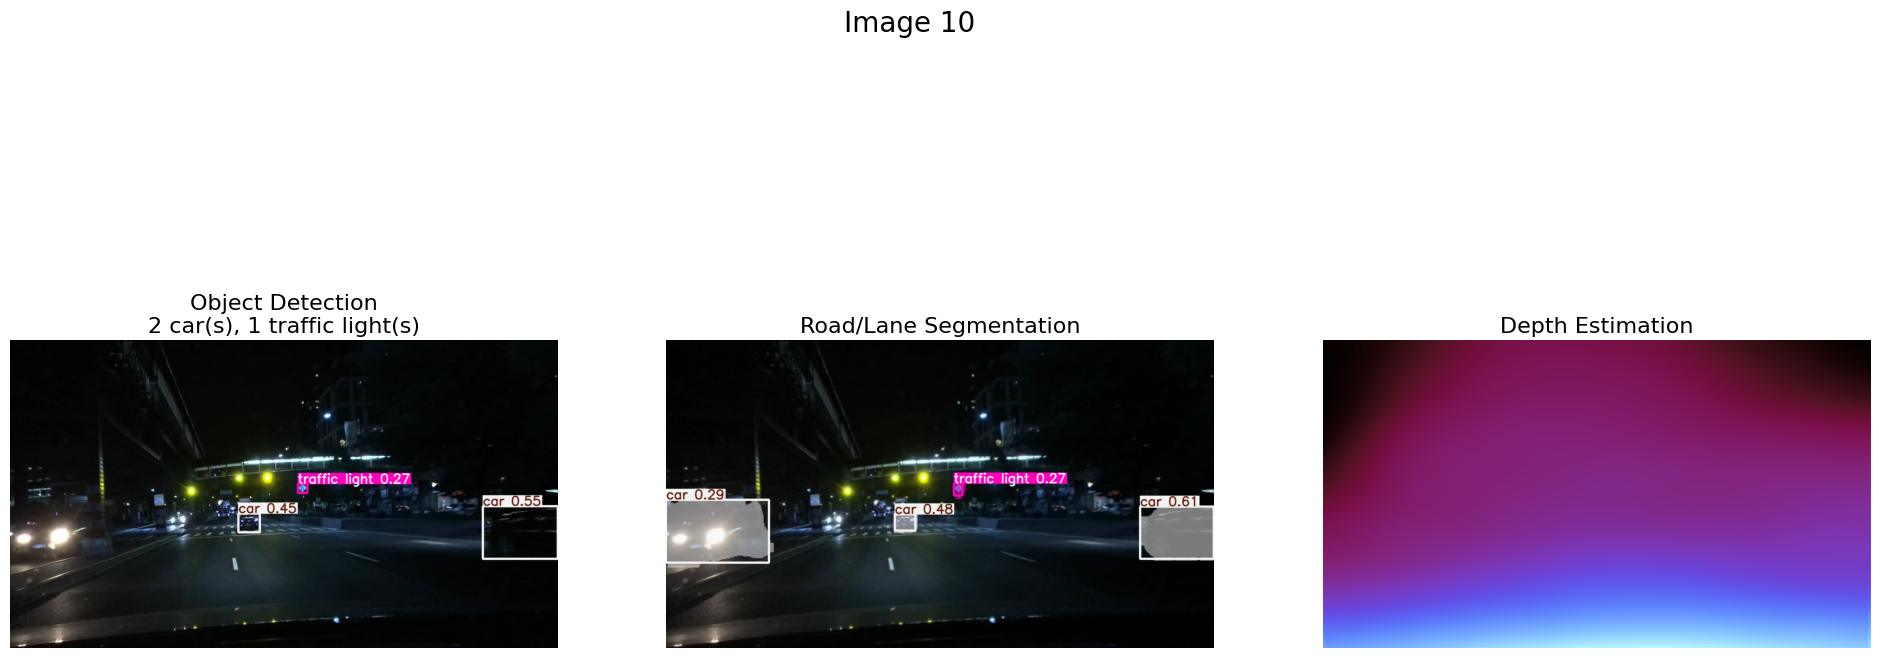

In [50]:
# ====================
# 🚦 Batch Perception on 10 Images
# ====================
samples = random.sample(unified_dataset, 10)

for i, sample in enumerate(samples):
    print(f"Running perception on sample {i+1}")
    result = perceive_image(sample)
    show_perception_result(result, title=f"Image {i+1}")
